In [1]:
%matplotlib inline

from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray
import xbout
import scipy
import xhermes
import re

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from hermes3.utils import *

import gridtools.solps_python_scripts.setup
from gridtools.solps_python_scripts.utilities.last10s       import read_last10s

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *

from code_comparison.code_comparison import *
from code_comparison.solps_pp import *
from code_comparison.viewer_2d import *


%load_ext autoreload
%autoreload 2

plt.close("all")
%matplotlib inline

print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

Done


# Overview

- In the previous studies, we saw lots of checkerboarding which appeared to lead to a massive heating of neutrals.
- Disabling NVn prevented checkerboarding but the massive heating was still there and neutral temperature was going up.
- I wondered if the pump is playing a role here because it's very sensitive to cross-field transport. 

# Hermes IO

In [2]:
casestore = dict()

In [3]:
   
db = CaseDB()
toload = [
    dict(name="base", id = "xph1-base_master"),
    dict(name="base_nocond", id = "xph1b-base_nocond"),

    dict(name="nonvn_polupwind_nopump", id = "xph6c-nopump"),
    dict(name="nonvn_polupwind_nopump_nocond", id = "xph6cb-nopump-nocond"),
    
    dict(name="nocx_nocond", id = "xph8-6cb_nocx"),
    
]
casestore = {}
for case in toload:
    force = True if case["name"] == "no_neutvisc" else False
    casestore[case["name"]] = db.load_case_2D(case["id"], use_squash = True, verbose = True, force_squash = force, use_xhermes = False)

- Reading case xph1-base_master
-----------------------
- Looking for squash file
- Squash file found. squash date 02/20/2024, 16:15:59, dmp file date 02/18/2024, 18:21:29

- Reading case xph1b-base_nocond
-----------------------
- Looking for squash file
- Squash file found. squash date 02/21/2024, 13:48:21, dmp file date 02/21/2024, 08:48:08

- Reading case xph6c-nopump
-----------------------
- Looking for squash file
- Squash file found. squash date 03/08/2024, 15:02:17, dmp file date 03/08/2024, 13:12:12

- Reading case xph6cb-nopump-nocond
-----------------------
- Looking for squash file
- Squash file found. squash date 03/08/2024, 15:03:10, dmp file date 03/08/2024, 14:21:25

- Reading case xph8-6cb_nocx
-----------------------
- Looking for squash file
- Squash file found. squash date 03/12/2024, 16:46:34, dmp file date 03/11/2024, 21:04:13



In [4]:
plt.close("all")
%matplotlib inline

## Read Hermes data

In [5]:
hr = dict()
for name in casestore.keys(): 
    print(name)
    hr[name] = Hermesdata()
    hr[name].read_case(casestore[name].ds.isel(t=-1, x = slice(2,-2)))
    
    if "afnE" in  name:
        new_afn = True
        print(f"Loading {name} with new AFN")
    else:
        new_afn = False
        print(f"Loading {name} with old AFN")
    
    ds = casestore[name].ds
    ds = calculate_radial_fluxes(ds, new_afn = new_afn)
    # ds = calculate_target_fluxes(ds)
    ds = reverse_pfr_fluxes(ds)

base
Loading base with old AFN
base_nocond
Loading base_nocond with old AFN
nonvn_polupwind_nopump
Loading nonvn_polupwind_nopump with old AFN
nonvn_polupwind_nopump_nocond
Loading nonvn_polupwind_nopump_nocond with old AFN
nocx_nocond
Loading nocx_nocond with old AFN


# Read SOLEDGE CSV data

In [6]:
soledgecases = {
    "tightwall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_1e19"), # Hermes-3 like wall
    "tightwall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_2e19"), # Hermes-3 like wall
    "widewall_2e19_5m" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19_5M"),
    "tightwall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_3e19"), # Hermes-3 like wall
    "widewall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_1e19"), 
    "widewall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19"), 
    "widewall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_3e19"), 
}

sl = dict()

for name in soledgecases:
    path = soledgecases[name]
    sl[name] = SOLEDGEdata(path = path)
    sl[name].read_csv(os.path.join(path, "omp_plasma.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "omp_neutrals.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "imp_plasma.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "imp_neutrals.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "wall_ntmpi_plasma.csv"), mode = "wall_ntmpi")



c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astyp

## Read SOLPS

In [7]:
solpscases = {
    "base" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5"),
    "noiz_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16"),
    "gammai_2.5" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=2.5E+00"),
    "dpuff_1e22" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22"),
    "dpuff_5e21" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=5.0E+21"),
    "no_fast_reflec" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.Pf=0"),
    "nsep_2e19" : os.path.join(onedrive_path,r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=2E+19"),
    "nsep_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=3E+19"),
    "narrow_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent"),
    "no_visc" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent.b2tqca_phm0=0"),
    "16x_mc" : os.path.join(onedrive_path, r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.xxx.BCCON=16.core_extent.MC.histories.x16-ish.NOT.converged"),
}

sp = dict()

for name in solpscases:
    sp[name] = SOLPSdata()
    sp[name].read_last10s(solpscases[name])

c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=2.5E+00\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\co

# Runtime

(0.0, 10000000.0)

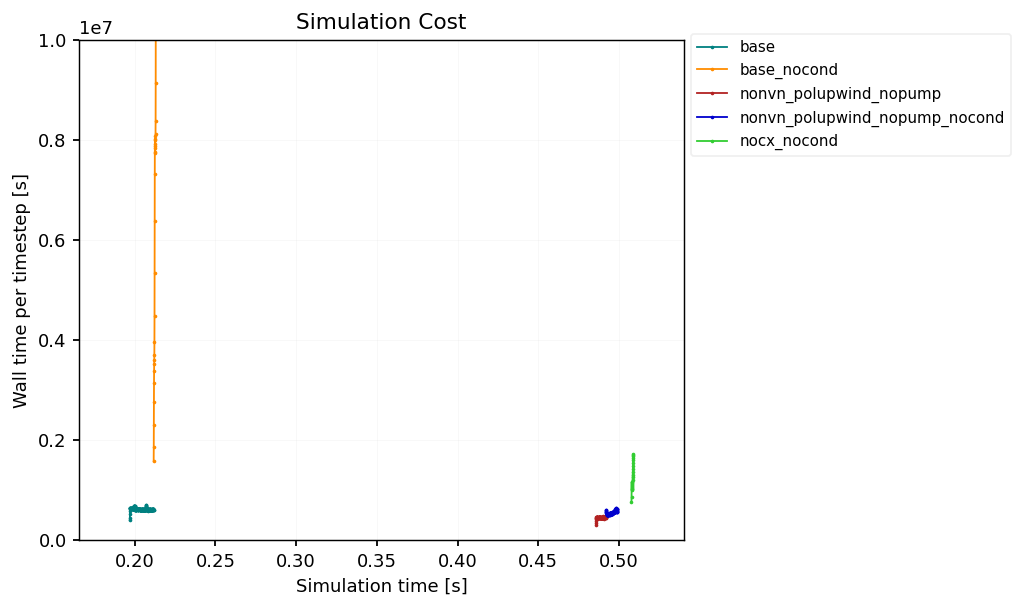

In [10]:
fig, ax = plt.subplots(dpi = 130)

colors = ["limegreen", "gold", "darkorange", "red", "firebrick", "skyblue", "navy"]

for i, case in enumerate(casestore):
    ds = casestore[case].ds
    wtime = ds["wtime"][:-1].values
    tstep = ds["t"].diff("t").values
    
    wtime_per_tstep = wtime/tstep
    time = ds["t"][:-1].values
    # time -= time[0]

    
    ax.plot(time, scipy.ndimage.gaussian_filter1d(wtime_per_tstep, 2), label = case,  lw = 1, marker = "o", ms = 1)
    
fig.legend(loc = "upper left", bbox_to_anchor=(0.9,0.9), fontsize="small")
ax.set_xlabel("Simulation time [s]")
ax.set_ylabel("Wall time per timestep [s]")
ax.set_title("Simulation Cost")
ax.set_ylim(0,1e7)
# ax.set_xlim(None,0.614688)

# Poloidal temps

(1, 10000)

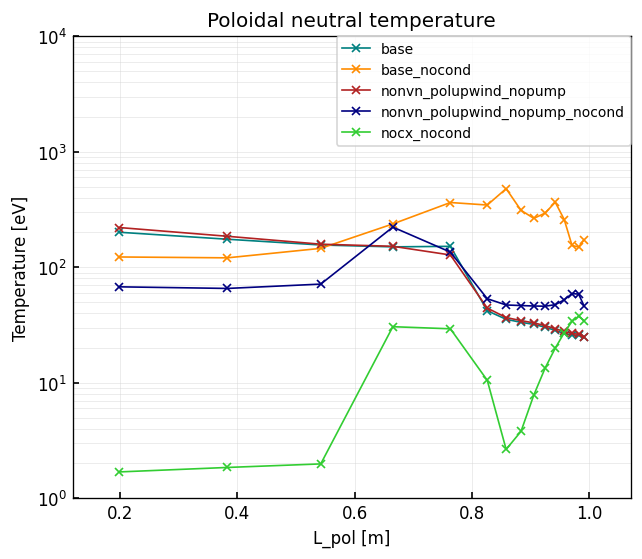

In [8]:
# locond = ['afnE', 'afnE_cond0.01', 'afnE_cond0.01_minmod_form1', 'afnE_cond0.01_minmod_form3', 'afnE_cond0.01_minmod_form2', 'afnE_cond0.25_form1', 'afnE_cond0.25_form2', 'afnE_cond0.25_form3', 'noafn_old', 'noafn_new']
colors = ["teal", "darkorange", "firebrick", "navy", "limegreen", "purple", "skyblue", "red"]
cases = [x for x in casestore.keys() if "minmod" not in x]

# colors = mpl.cm.get_cmap("plasma", len(cases))(range(len(cases)))
fig, ax = plt.subplots(dpi = 120)

for i, case in enumerate(cases):
    ds = casestore[case].ds.isel(t=-1)
    m = ds.metadata
    fl = ds.isel(x = m["ixseps1"], theta = slice(41,-2))
    dist = np.cumsum(fl["dl"])
    
    if any([x in case for x in ["form2", "form4"]]):
        m = "x"
    elif any([x in case for x in ["form1", "form3"]]):
        m = "+"
    else:
        m = "x"
    ax.plot(dist, fl["Td"], label = case, marker = m, ms = 5, lw = 1, color = colors[i])
	
    # ax.plot(dist, fl["Td+"],  marker = "o", ms = 5, lw = 0.5, c = colors[i])
# ax.set_yscale("symlog", linthresh = 1e-3)
ax.set_xlabel("L_pol [m]")
ax.set_ylabel("Temperature [eV]")
ax.set_title("Poloidal neutral temperature")
ax.legend(fontsize="small")
ax.set_yscale("log")
ax.set_ylim(1,10000)


# Investigate seam

In [10]:
casestore.keys()

dict_keys(['base', 'base_nocond', 'nonvn_polupwind_nopump', 'nonvn_polupwind_nopump_nocond', 'nocx_nocond'])

In [14]:
ds.dims

Frozen({'x': 20, 'theta': 58, 't': 26})

IndexError: index 35 is out of bounds for axis 0 with size 20

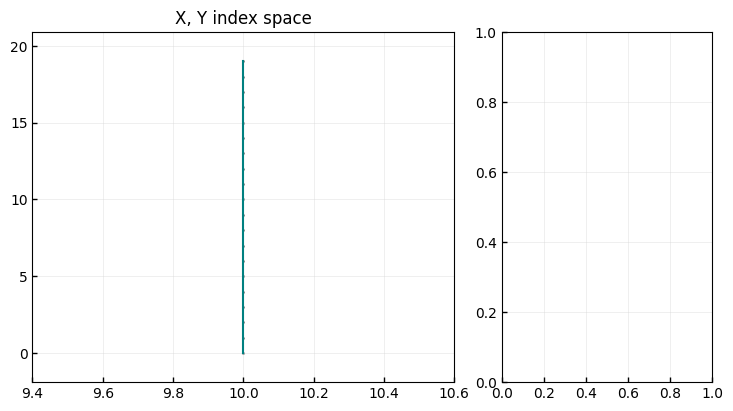

In [13]:
ds = casestore["nocx_nocond"].ds

sel = dict(x = slice(None,None), theta = 10)
plot_selection(ds[sel], ds)

# Lineplots

In [13]:
casestore.keys()

dict_keys(['base', 'base_nocond', 'nonvn_polupwind_nopump', 'nonvn_polupwind_nopump_nocond', 'nocx_nocond'])

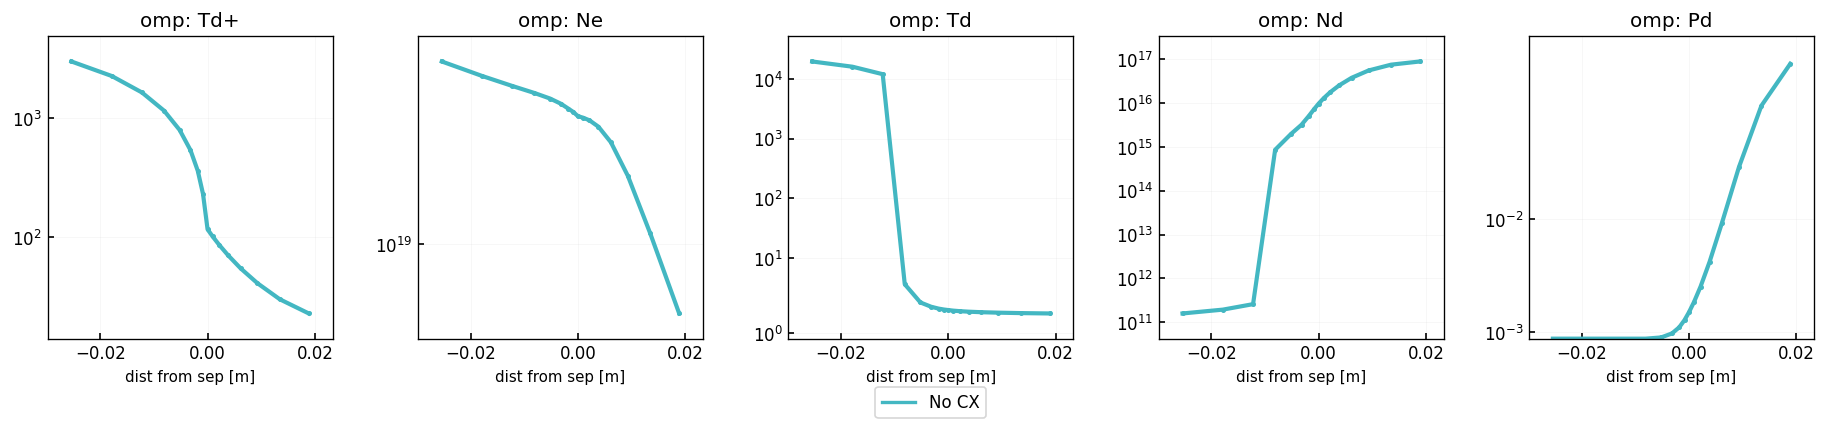

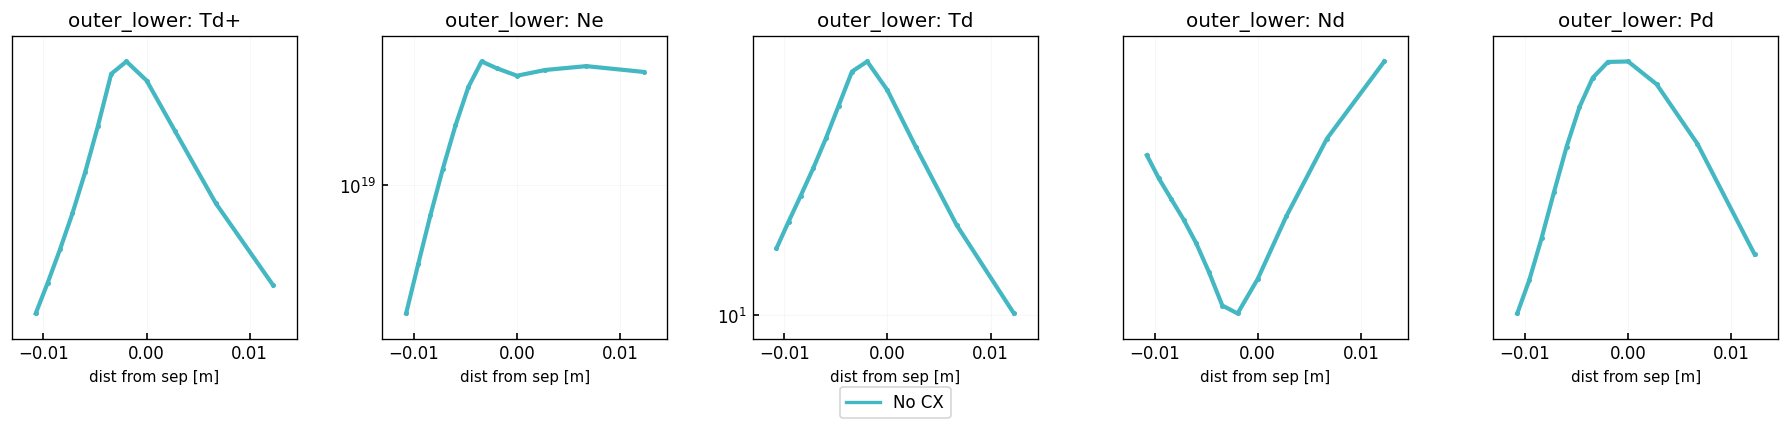

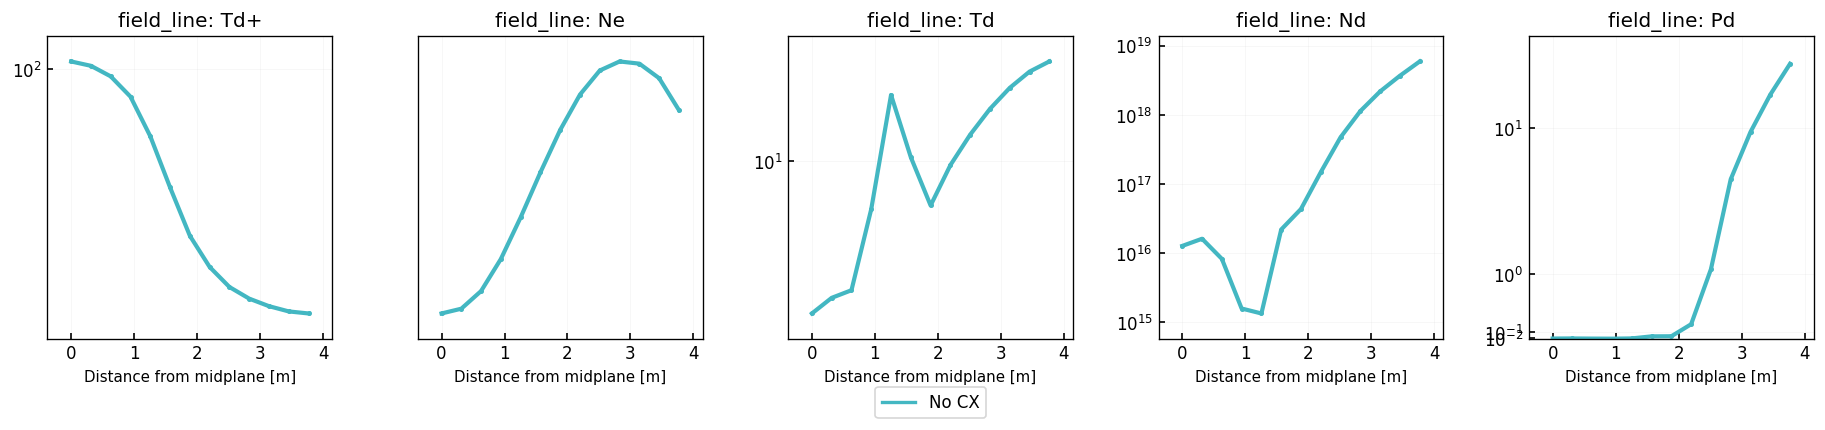

In [9]:

lineplot(
    {
        # "MC":casestore["base"].ds.isel(t=-1),
        # "nocond, t=3":casestore["base_nocond"].ds.isel(t=3),
        # "MC nocond":casestore["base_nocond"].ds.isel(t=-1),
        # "minmod nocond":casestore["minmod_nocond"].ds.isel(t=-1),
        # "No NVn nocond":casestore["nonvn_nocond"].ds.isel(t=-1),
        # "No NVn upwind nocond":casestore["nonvn_upwind_nocond"].ds.isel(t=-1),
        # "No NVn pol. upwind":casestore["nonvn_polupwind_nopump"].ds.isel(t=-1),
        # "No NVn pol. upwind nocond":casestore["nonvn_polupwind_nopump_nocond"].ds.isel(t=-1),
        "No CX":casestore["nocx_nocond"].ds.isel(t=-1),
    },
    clean_guards = True,
    logscale = True,
    params = ["Td+", "Ne", "Td", "Nd", "Pd"],
    regions = ["omp", "outer_lower", "field_line"],
)

(0.15, 0.81)

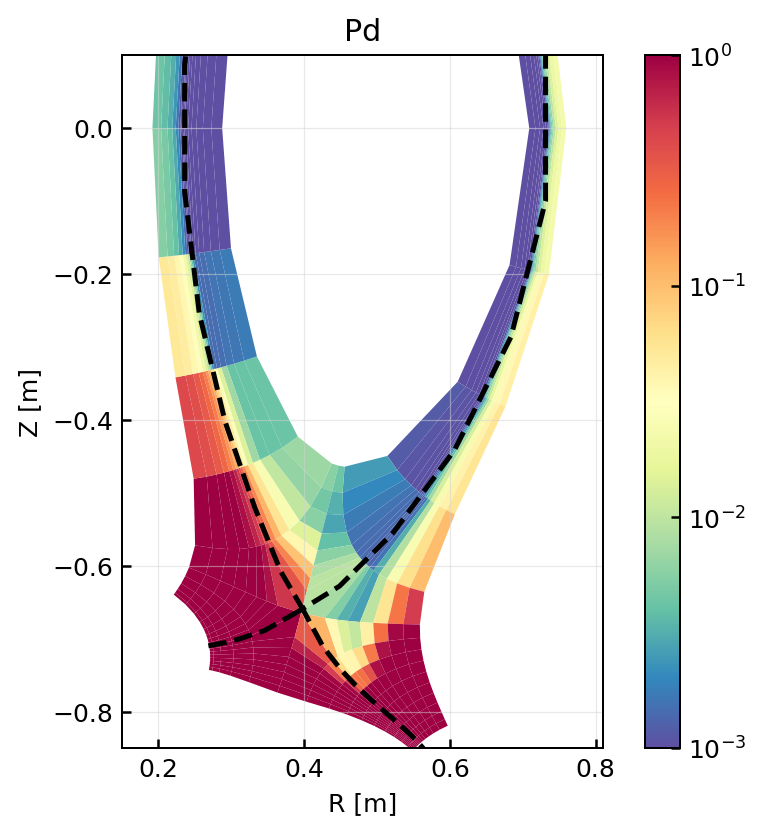

In [16]:
fig, ax = plt.subplots(dpi = 180)

ds = casestore["nocx_nocond"].ds.isel(t=-1)
ds["Pd"].hermesm.clean_guards().bout.polygon(
    ax, cmap = "Spectral_r", 
    vmax = 1, vmin = 1e-3, 
    antialias = True, targets = False, logscale = True)
ax.set_ylim(-0.85, 0.1)
ax.set_xlim(0.15,0.81)

## Lineplots vs. soledge

In [ ]:

plt.close("all")
lineplot_compare(
    cases = { 


    "SOLEDGE: 2e19 (tight)" : dict(data=sl["tightwall_2e19"], color="black"),
    r"Hermes-3: base" : dict(data=hr['base'], color = "teal"),


    },
    regions = ["omp", "imp", "outer_lower", "outer_fieldline"], 
    # regions = ["omp"],
    # regions = ["outer_lower"],
    # params = ["Ne", "Te"],
    params = ["Ne", "Te", "Td+", "Na", "Ta"],
    # params = ["Na", "Ta"],
    # params = ["Pe", "Pd+", "Pa"],
    combine_molecules = True,
    mode = "log",
    dpi = 120,
    lw = 2
)

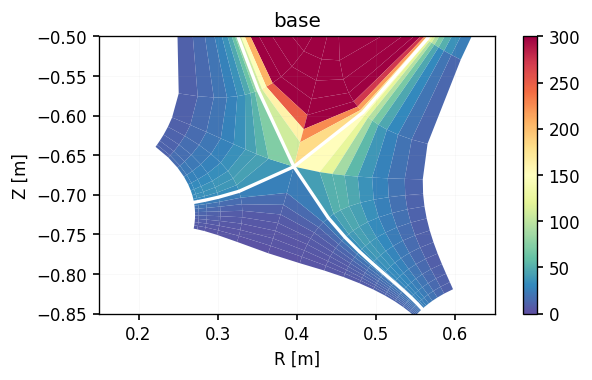

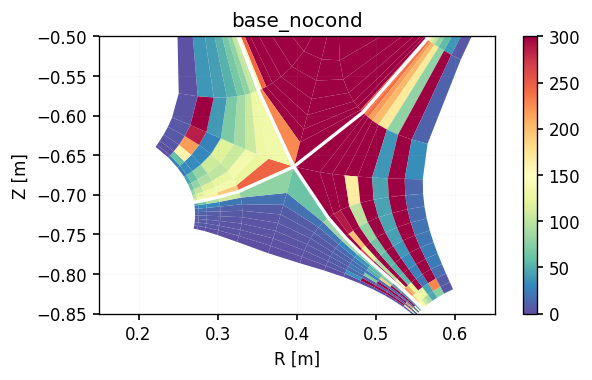

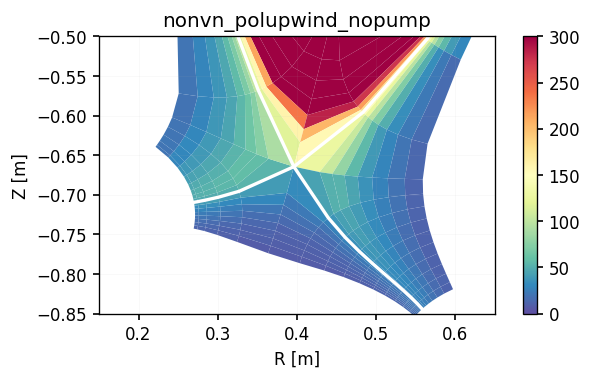

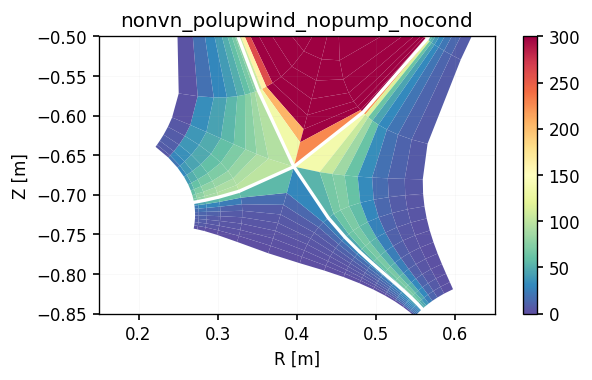

In [13]:
for case in [x for x in casestore.keys() if "notune" not in x]:
    fig, ax = plt.subplots(figsize = (6,3))
    ds = casestore[case].ds.isel(t=-1)
    ds["Td"].hermesm.clean_guards().bout.polygon(ax, cmap = "Spectral_r", vmax = 300, vmin = 0, antialias = True)
    ax.set_ylim(-0.85, -0.5)
    ax.set_xlim(0.15,0.65)
    ax.set_title(case)

In [14]:
casestore.keys()

dict_keys(['base', 'base_nocond', 'nonvn_polupwind_nopump', 'nonvn_polupwind_nopump_nocond'])

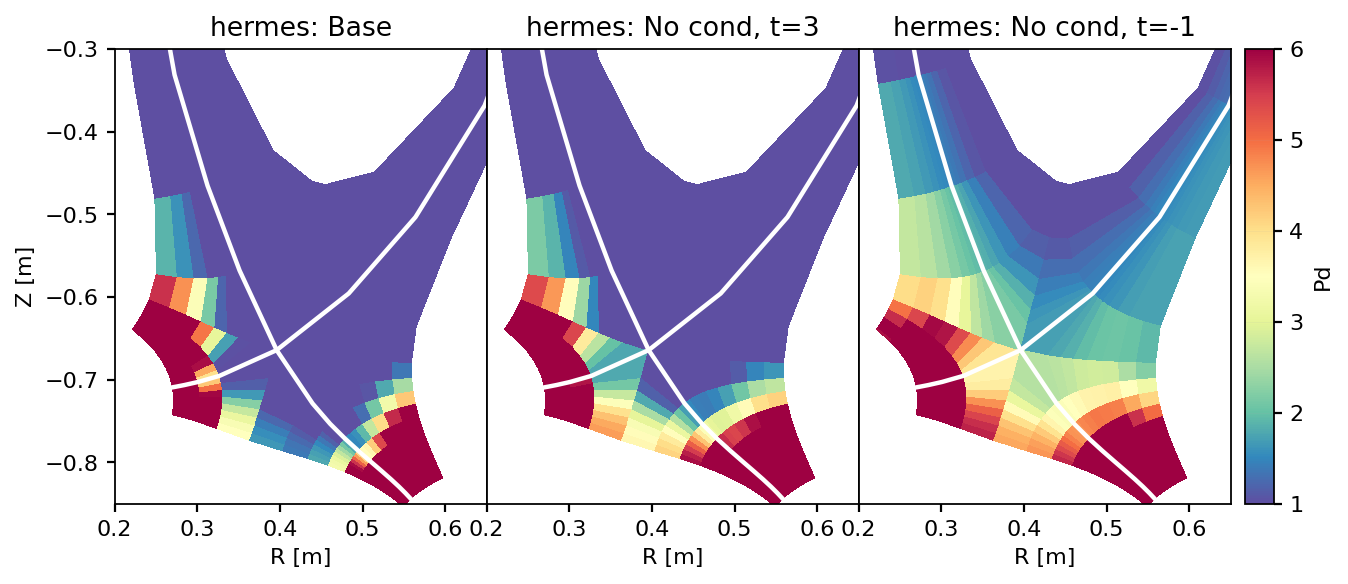

In [13]:
plt.close("all")
v = viewer_2d(
    "Pd",
    [
        # {"name" : "Tight wall", "code":"soledge", "path" : soledgecases["tightwall_2e19"]},
        {"name" : r"Base", "code" : "hermes", "ds" : casestore['base'].ds.isel(t=-1)},
        {"name" : r"No cond, t=3", "code" : "hermes", "ds" : casestore['nonvn_polupwind_nopump'].ds.isel(t=3)},
        {"name" : r"No cond, t=-1", "code" : "hermes", "ds" : casestore['nonvn_polupwind_nopump_nocond'].ds.isel(t=-1)},
    ],
    logscale = False,
    vmin = 1,
    vmax = 6,
    # vmin = 1e15,
    # vmax = 1e19,
    dpi = 160,
    ylim = (-0.85,-0.3),
    xlim = (0.2, 0.65),
    wspace = 0.0,
    cmap = "Spectral_r",
    slider = False,
)

# Analyse new nocond case

In [16]:
casestore.keys()

dict_keys(['base', 'base_nocond', 'nonvn_polupwind_nopump', 'nonvn_polupwind_nopump_nocond', 'nocx_nocond'])

Density floor: 1.0e+12 m^-3
Pressure floor: 1.6e-05 Pa


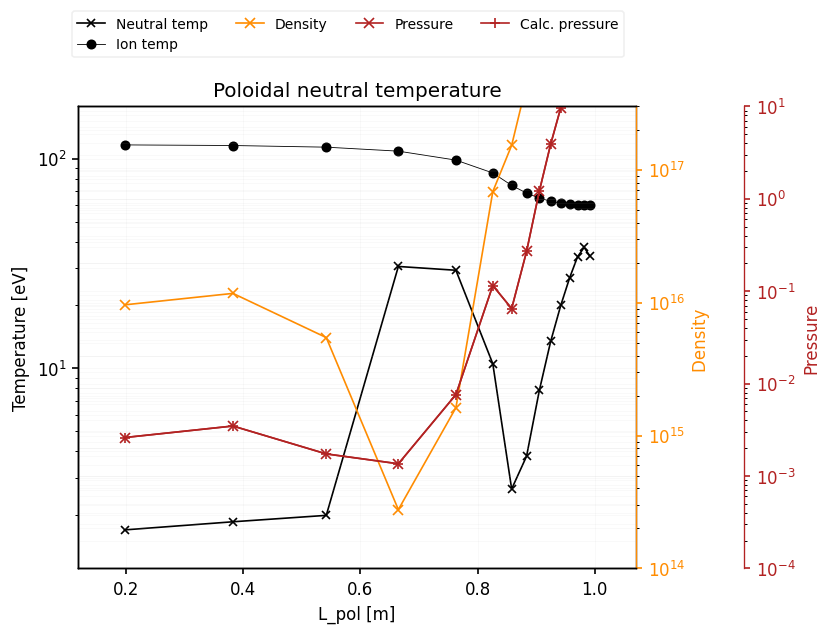

In [22]:

colors = ["teal", "darkorange", "firebrick", "navy", "limegreen", "purple", "skyblue", "red"]
cases = ['nocx_nocond']

# colors = mpl.cm.get_cmap("plasma", len(cases))(range(len(cases)))
fig, ax = plt.subplots(dpi = 120)


ds = casestore[case].ds.isel(t=-1)
m = ds.metadata
# fl = ds.isel(x = m["ixseps1"], theta = slice(2,15))
fl = ds.isel(x = m["ixseps1"], theta = slice(41,-2))
dist = np.cumsum(fl["dl"])


ax.plot(dist, fl["Td"], label = "Neutral temp", marker = "x", ms = 5, lw = 1, color = "k")
ax.plot(dist, fl["Td+"],  label = "Ion temp", marker = "o", ms = 5, lw = 0.5, c ="k")
# ax.set_yscale("symlog", linthresh = 1e-3)
ax.set_yscale("log")
ax.set_xlabel("L_pol [m]")
ax.set_ylabel("Temperature [eV]")
ax.set_title("Poloidal neutral temperature")

ax2 = ax.twinx()
ax2color = "darkorange"
ax2.plot(dist, fl["Nd"], label = "Density", c = ax2color, marker = "x", lw = 1)
ax2.set_yscale("log")
ax2.set_ylim(1e14,3e17)
ax2.set_ylabel("Density ", color = ax2color)
ax2.spines["right"].set_color(ax2color)
ax2.tick_params(axis = "y", colors = ax2color)

ax3 = ax.twinx()
ax3color = "firebrick"
ax3.plot(dist, fl["Pd"], label = "Pressure", c = ax3color, marker = "x", lw = 1)
ax3.plot(dist, fl["Nd"] * fl["Td"] * constants("q_e"), label = "Calc. pressure", marker = "+", lw = 1, c = ax3color)
ax3.set_yscale("log")
ax3.set_ylim(0.0001,10)
ax3.set_ylabel("Pressure", color = ax3color)
ax3.spines["right"].set_color(ax3color)
ax3.spines["right"].set_position(("outward", 65))
ax3.tick_params(axis = "y", colors = ax3color)


fig.legend(loc = "lower center", bbox_to_anchor = (0.5, 0.95), ncols = 4, fontsize="small")
# ax.set_yscale("log")
# ax.set_ylim(10,10000)

print(f"Density floor: {1e-5 * 1e17:.1e} m^-3")
print(f"Pressure floor: {1e-5 * 1e17 * 100 * constants('q_e'):.1e} Pa")

Density floor: 1.0e+12 m^-3
Pressure floor: 1.6e-05 Pa


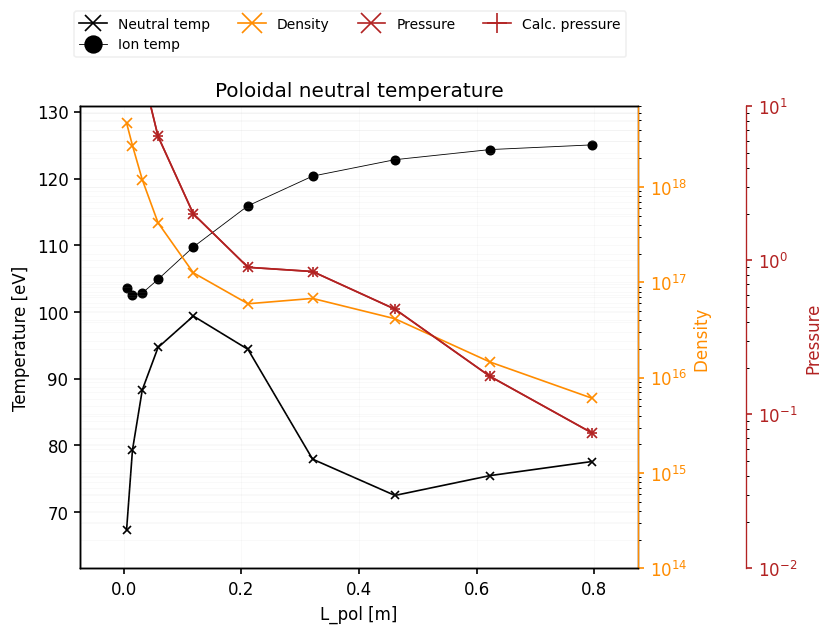

In [81]:

colors = ["teal", "darkorange", "firebrick", "navy", "limegreen", "purple", "skyblue", "red"]
cases = ['nonvn_polupwind_nopump_nocond']

# colors = mpl.cm.get_cmap("plasma", len(cases))(range(len(cases)))
fig, ax = plt.subplots(dpi = 120)


ds = casestore[case].ds.isel(t=-1)
m = ds.metadata
fl = ds.isel(x = m["ixseps1"], theta = slice(2,12))
dist = np.cumsum(fl["dl"])


ax.plot(dist, fl["Td"], label = "Neutral temp", marker = "x", ms = 5, lw = 1, color = "k")
ax.plot(dist, fl["Td+"],  label = "Ion temp", marker = "o", ms = 5, lw = 0.5, c ="k")
# ax.set_yscale("symlog", linthresh = 1e-3)
ax.set_xlabel("L_pol [m]")
ax.set_ylabel("Temperature [eV]")
ax.set_title("Poloidal neutral temperature")

ax2 = ax.twinx()
ax2color = "darkorange"
ax2.plot(dist, fl["Nd"], label = "Density", c = ax2color, marker = "x", lw = 1)
ax2.set_yscale("log")
ax2.set_ylim(1e14,7e18)
ax2.set_ylabel("Density ", color = ax2color)
ax2.spines["right"].set_color(ax2color)
ax2.tick_params(axis = "y", colors = ax2color)

ax3 = ax.twinx()
ax3color = "firebrick"
ax3.plot(dist, fl["Pd"], label = "Pressure", c = ax3color, marker = "x", lw = 1)
ax3.plot(dist, fl["Nd"] * fl["Td"] * constants("q_e"), label = "Calc. pressure", marker = "+", lw = 1, c = ax3color)
ax3.set_yscale("log")
ax3.set_ylim(0.01,10)
ax3.set_ylabel("Pressure", color = ax3color)
ax3.spines["right"].set_color(ax3color)
ax3.spines["right"].set_position(("outward", 65))
ax3.tick_params(axis = "y", colors = ax3color)


fig.legend(loc = "lower center", bbox_to_anchor = (0.5, 0.95), ncols = 4, fontsize="small")
# ax.set_yscale("log")
# ax.set_ylim(10,10000)

print(f"Density floor: {1e-5 * 1e17:.1e} m^-3")
print(f"Pressure floor: {1e-5 * 1e17 * 100 * constants('q_e'):.1e} Pa")

C:\Users\mikek\AppData\Local\Temp\ipykernel_70784\2368040841.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = mpl.cm.get_cmap("plasma", len(indices))(range(len(indices)))


(0.15, 0.65)

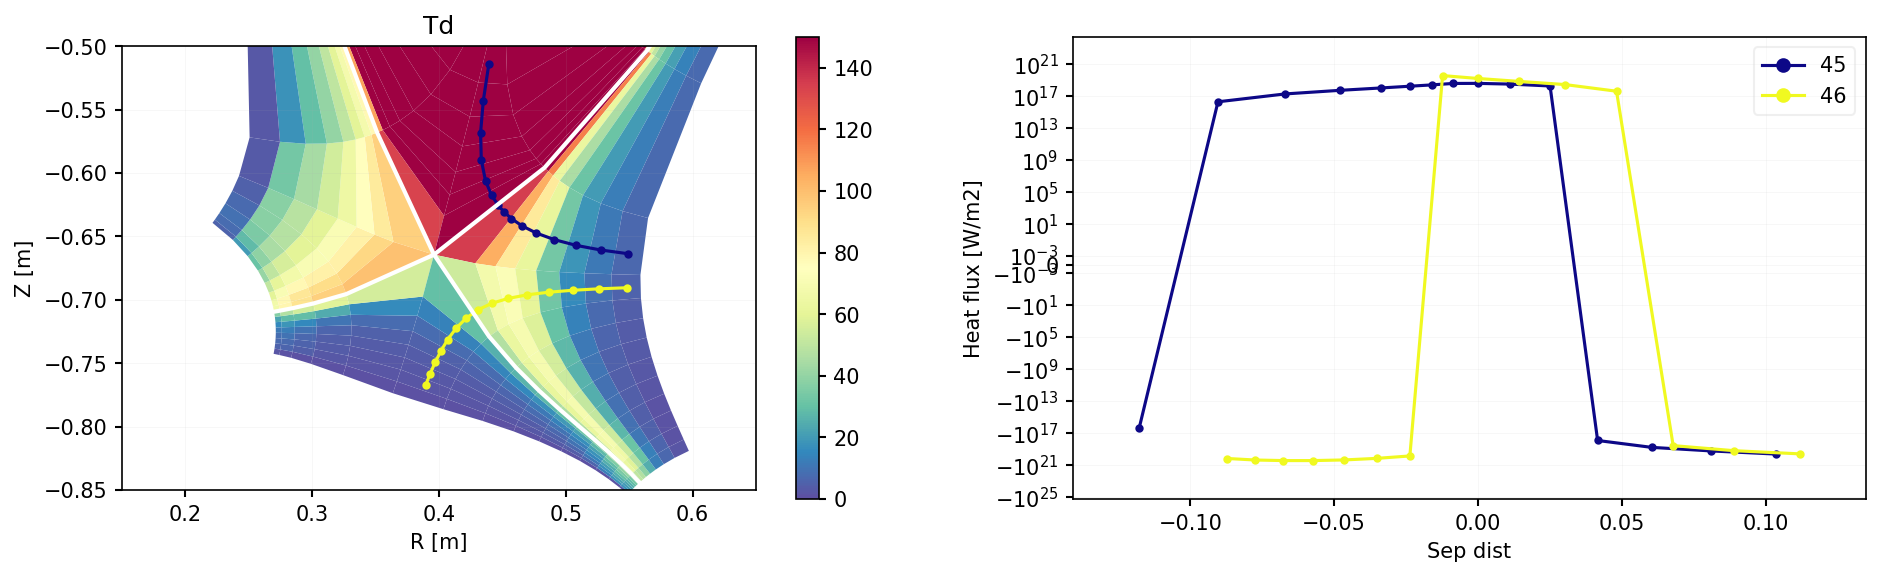

In [70]:
ds = casestore["nonvn_polupwind_nopump_nocond"].ds.isel(t=-1)

fig, axes = plt.subplots(1,2, figsize = (15,4), dpi = 150)

indices = range(45,47)
colors = mpl.cm.get_cmap("plasma", len(indices))(range(len(indices)))

for i, theta_idx in enumerate(indices):
    sl = ds.isel(theta = theta_idx, x = slice(3, -2))
    dist = np.cumsum(sl["dr"])
    dist -= dist[m["ixseps1"]-2]

    axes[1].plot(dist, sl["pf_perp_diff_L_d"]/(sl["dy"]*sl["dz"]), marker = "o", ms = 3, label = theta_idx, color = colors[i])
    axes[0].plot(sl["R"], sl["Z"], marker = "o", ms = 3,  color = colors[i])
    # ax.plot(dist, sl["Td+"], marker = "o", label = theta_idx, color = colors[i])
    
axes[1].legend()
axes[1].set_yscale("symlog", linthresh = 1e-3)
axes[1].set_xlabel("Sep dist")
axes[1].set_ylabel("Heat flux [W/m2]")
axes[1].set_title("")

ds["Td"].hermesm.clean_guards().bout.polygon(ax = axes[0], cmap = "Spectral_r", vmax = 150, vmin = 0, antialias = True)


axes[0].set_ylim(-0.85, -0.5)
axes[0].set_xlim(0.15,0.65)

(0.15, 0.65)

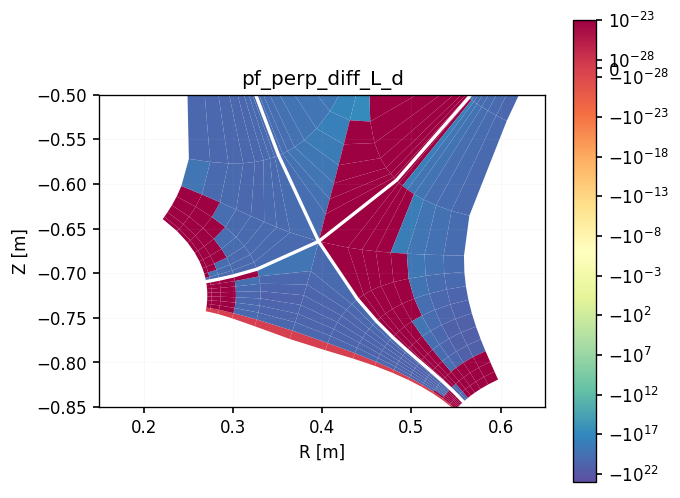

In [74]:
fig, ax = plt.subplots()
ds["pf_perp_diff_L_d"].hermesm.clean_guards().bout.polygon(ax = ax, cmap = "Spectral_r", vmax = 1e-23, vmin = -1e23, antialias = True, logscale = True)
ax.set_ylim(-0.85, -0.5)
ax.set_xlim(0.15,0.65)